In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


import rdkit 
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys

In [86]:
import hdbscan
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans

In [21]:
%matplotlib inline
%config InlineBackend.figure_format =   'svg'

# CT colors: blue x 3, gray x 3, pink x 3
# Shades and Tints from https://www.colorhexa.com/da6388
CT_cols = ['#4a79a5', '#93b4d2', '#e6edf4',
           '#848688', '#b5b6b7', '#f2f2f2'
           '#da6388', '#eaa9be', '#f4d2dd' ]

In [195]:
def mol2fp(mol, radi=2, nBits=1024):
    # fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radi, nBits=nBits)
    fp = MACCSkeys.GenMACCSKeys(mol)
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [4]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [5]:
from matplotlib.colors import LinearSegmentedColormap
cma = get_continuous_cmap([CT_cols[0], CT_cols[7]])

# Read // Write

In [6]:
dfile = "../data/raw/train.csv"

In [7]:
smi_file = "../data/derived/compounds_desalt.smi"


In [8]:
df = pd.read_csv(dfile, index_col=0)


In [177]:
df.index

Index(['EOS12286', 'EOS85869', 'EOS85435', 'EOS102302', 'EOS64213', 'EOS68602',
       'EOS90323', 'EOS4636', 'EOS72860', 'EOS18993',
       ...
       'EOS40121', 'EOS80084', 'EOS366', 'EOS39302', 'EOS67619', 'EOS37839',
       'EOS2088', 'EOS10587', 'EOS40533', 'EOS45458'],
      dtype='object', name='Id', length=70711)

In [179]:
smiles = []
ind_names = []
smiles_dict = {}
with open(smi_file, 'r') as iFile:
    for i, s in enumerate(iFile):
        S = s.strip().split()
        if S[1] in df.index:
            smiles.append([S[0], i])
            ind_names.append(S[1])
            smiles_dict[S[1]] = S[0]

In [180]:
all_mols = []
for i in list(smiles_dict):
    m = Chem.MolFromSmiles(smiles_dict[i])
    m.SetProp("_Name",i)
    all_mols.append(m)

In [199]:
all_fp = []
for m in all_mols:
    a = mol2fp(m)
    all_fp.append(a)
all_fp = np.array(all_fp)

In [200]:
a.shape

(167,)

# Clustering

## PCA

In [201]:
pca = PCA(n_components=5)
X_r = pca.fit(all_fp).transform(all_fp)

In [202]:
pca.explained_variance_ratio_

array([0.12863924, 0.07636858, 0.06989654, 0.05780637, 0.04015828])

In [203]:
X_r.shape

(70711, 5)

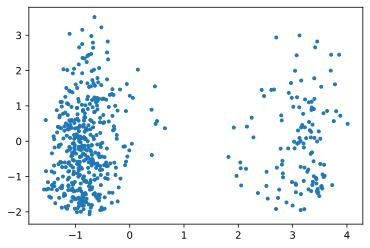

In [206]:
plt.plot(X_r[::125,0], X_r[::125,1],'.')

In [208]:
y_pred = KMeans(n_clusters=2500, random_state=220).fit_predict(X_r)

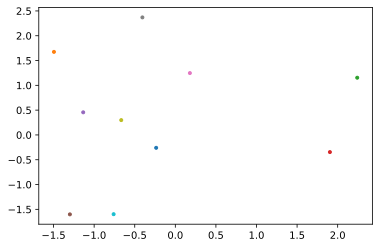

In [209]:
for i in np.unique(y_pred[:10]):
    labs = y_pred==i
    x = X_r[labs, 0]
    y = X_r[labs, 1]
    plt.plot(x[::50],y[::50], '.')

# What clusters are?

In [222]:
mask = y_pred==1218

In [223]:
all_mols = np.array(all_mols)

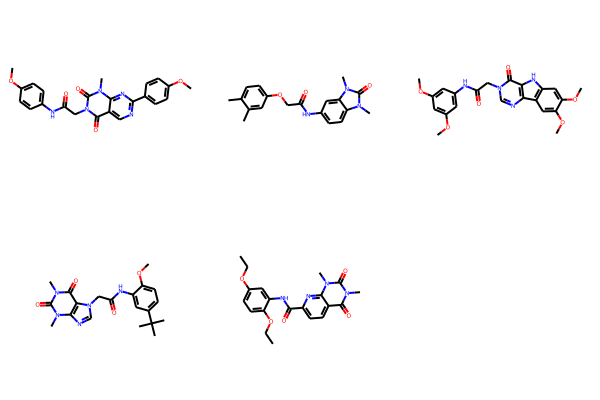

In [254]:
mols = all_mols[mask]
Draw.MolsToGridImage((mols[:5]))

## Analysis of composition

In [243]:
solubilities = df['sol_category'].values
sol_proc = np.sum(solubilities>1) / len(solubilities)
insol_proc = np.sum(solubilities<2) / len(solubilities)

In [251]:
for i in np.unique(y_pred):
    mask = y_pred==i
    inx = np.array(ind_names)[mask]
    sol_proc_clus = np.sum(df.loc[inx, 'sol_category'].values > 1) / len(inx)
    if abs(sol_proc - sol_proc_clus) > 0.2:
        print(len(inx), i)

15 108
32 126
22 891
8 958
7 998
7 1152
27 1190
7 1212
10 1237
22 1287
9 1479
6 1593
6 1597
18 1634
25 2080
11 2207
14 2286
26 2352


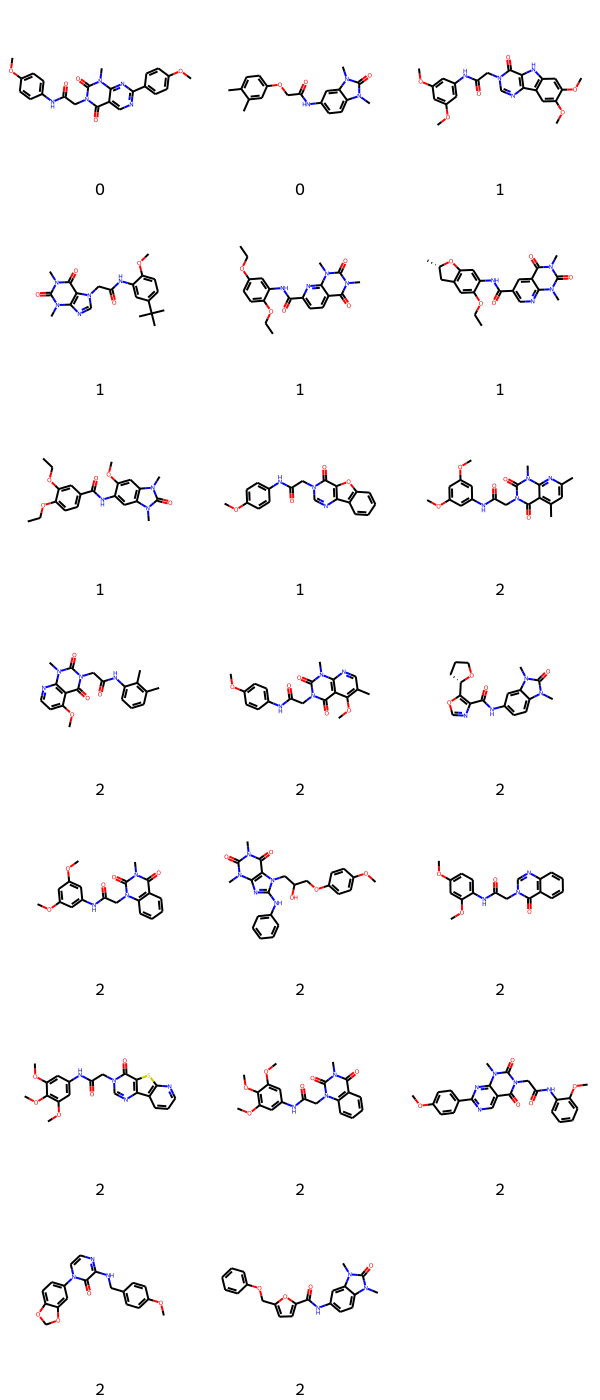

In [306]:
n=20

mask = y_pred==2352

inx = np.array(ind_names)[mask]
sol_proc_clus = np.sum(df.loc[inx, 'sol_category'].values > 1) / len(inx)
labs = df.loc[inx, 'sol_category'].values
mols = all_mols[mask]
Draw.MolsToGridImage(mols[:n],legends=list(np.array(labs[:n], dtype=str)))

In [283]:
np.array(labs, dtype=str)

array(['0', '1', '2', '2', '2', '2'], dtype='<U21')

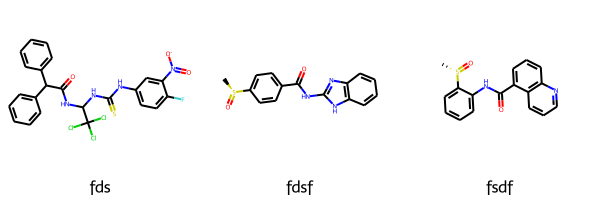

In [281]:
Vvg